# Georgia
We will be analyzing the congressional district maps in Georgia followwing the 2020 census. Currently Georgia's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election. We will be looking at their 2021 plan which was used for the 2022 election and then a new 2023 plan which was used in the 2024 election. The 2023 plan was a placeholder to fix some of the issues with the 2021 so the 2024 election would have a less problematic map.

## Import Required Packages

In [233]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Setting up our dataset
We want all the senate election results and voter demographics by precincts, so we will have to merge different datasets to do so. This section works through the code to create our desired shapefile dataset which we will save to github so we don't have to run the joins everytime we do analysis.

### Import Congressional Districting Plans

In [234]:
ga_2023_gdf = gpd.read_file("congress-2023-shape/Congress-2023-shape.shp")
ga_2021_gdf = gpd.read_file("congress-prop1-2021-shape/CONGRESS-PROP1-2021-shape.shp")

We need to confirm that there aren't any issues in the Districts, so we can use the "maup" package.

In [235]:
# Check geodataframe using maup's doctor function
maup.doctor(ga_2023_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

In [236]:
maup.doctor(ga_2021_gdf)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


True

We are good to use these shapefiles.

### Import and Tidy Election Data

In [237]:
# Import 2022 General Election voting data
ga_data_gdf = gpd.read_file('ga_2022_gen_st_prec/ga_2022_gen_st_prec.shp')
ga_data_gdf.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'G22A01NO', 'G22A01YES',
       'G22A02NO', 'G22A02YES', 'G22AGRDHEM', 'G22AGRLRAU', 'G22AGRRHAR',
       'G22ATGDJOR', 'G22ATGLCOW', 'G22ATGRCAR', 'G22GOVDABR', 'G22GOVLHAZ',
       'G22GOVRKEM', 'G22INSDROB', 'G22INSRKIN', 'G22LABDBOD', 'G22LABLAND',
       'G22LABRTHO', 'G22LTGDBAI', 'G22LTGLGRA', 'G22LTGRJON', 'G22RFANO',
       'G22RFAYES', 'G22RFBNO', 'G22RFBYES', 'G22SOSDNGU', 'G22SOSLMET',
       'G22SOSRRAF', 'G22SUPDSEA', 'G22SUPRWOO', 'G22USSDWAR', 'G22USSLOLI',
       'G22USSRWAL', 'geometry'],
      dtype='object')

In [238]:
# List of specific columns to keep
columns_to_keep = ['UNIQUE_ID', 'COUNTYFP', 'county', 'precinct', 'geometry']

# Add columns starting with 'G22USS'
filtered_columns = columns_to_keep + [col for col in ga_data_gdf.columns if col.startswith('G22USS')]

# Filter the GeoDataFrame
ga_data_gdf = ga_data_gdf[filtered_columns]

# Check that we've kept the right stuff
ga_data_gdf

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL
0,001-1B,1,Appling,1B,"POLYGON ((-82.37653 31.83940, -82.37665 31.839...",86,15,721
1,001-1C,1,Appling,1C,"POLYGON ((-82.49759 31.81825, -82.49872 31.818...",51,6,571
2,001-2,1,Appling,2,"POLYGON ((-82.35743 31.78134, -82.35859 31.781...",641,11,393
3,001-3A1,1,Appling,3A1,"POLYGON ((-82.19971 31.83475, -82.20023 31.834...",23,8,493
4,001-3C,1,Appling,3C,"POLYGON ((-82.30075 31.67965, -82.30342 31.683...",213,5,726
...,...,...,...,...,...,...,...,...
2727,215-215FTBEN1,215,Muscogee,215FTBEN1,"POLYGON ((-84.89897 32.44577, -84.89896 32.449...",0,0,0
2728,215-215FTBEN2,215,Muscogee,215FTBEN2,"POLYGON ((-84.90494 32.40433, -84.90359 32.404...",0,0,0
2729,215-215FTBEN3,215,Muscogee,215FTBEN3,"POLYGON ((-84.93357 32.38090, -84.93369 32.380...",0,0,0
2730,215-215FTBEN4,215,Muscogee,215FTBEN4,"POLYGON ((-84.90960 32.42292, -84.90933 32.422...",0,0,0


Now we will assign precincts to congressional districts.

In [239]:
precincts_to_districts_2021 = maup.assign(ga_data_gdf.geometry, ga_2021_gdf.geometry)
precincts_to_districts_2021

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

0       10
1       10
2       10
3       10
4       10
        ..
2727     8
2728     8
2729     8
2730     8
2731     8
Length: 2732, dtype: int64

In [240]:
# Check that the assingment went smootly: that all precints have an assigned congressional district
ga_data_gdf[precincts_to_districts_2021.isna()]

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL


In [241]:
precincts_to_districts_2023 = maup.assign(ga_data_gdf.geometry, ga_2023_gdf.geometry)
precincts_to_districts_2023

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

0       2
1       2
2       2
3       2
4       2
       ..
2727    0
2728    0
2729    0
2730    0
2731    0
Length: 2732, dtype: int64

In [242]:
# Check that the assingment went smootly: that all precints have an assigned congressional district
ga_data_gdf[precincts_to_districts_2023.isna()]

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL


Now we will add these two assignment columns to the election data geodataframe so that we know what congressional district the precinct is in for the 2021 plan and for the 2023 plan.

In [243]:
ga_data_gdf["DISTRICT-CONG-2021"] = precincts_to_districts_2021
ga_data_gdf["DISTRICT-CONG-2023"] = precincts_to_districts_2023

ga_data_gdf

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL,DISTRICT-CONG-2021,DISTRICT-CONG-2023
0,001-1B,1,Appling,1B,"POLYGON ((-82.37653 31.83940, -82.37665 31.839...",86,15,721,10,2
1,001-1C,1,Appling,1C,"POLYGON ((-82.49759 31.81825, -82.49872 31.818...",51,6,571,10,2
2,001-2,1,Appling,2,"POLYGON ((-82.35743 31.78134, -82.35859 31.781...",641,11,393,10,2
3,001-3A1,1,Appling,3A1,"POLYGON ((-82.19971 31.83475, -82.20023 31.834...",23,8,493,10,2
4,001-3C,1,Appling,3C,"POLYGON ((-82.30075 31.67965, -82.30342 31.683...",213,5,726,10,2
...,...,...,...,...,...,...,...,...,...,...
2727,215-215FTBEN1,215,Muscogee,215FTBEN1,"POLYGON ((-84.89897 32.44577, -84.89896 32.449...",0,0,0,8,0
2728,215-215FTBEN2,215,Muscogee,215FTBEN2,"POLYGON ((-84.90494 32.40433, -84.90359 32.404...",0,0,0,8,0
2729,215-215FTBEN3,215,Muscogee,215FTBEN3,"POLYGON ((-84.93357 32.38090, -84.93369 32.380...",0,0,0,8,0
2730,215-215FTBEN4,215,Muscogee,215FTBEN4,"POLYGON ((-84.90960 32.42292, -84.90933 32.422...",0,0,0,8,0


### Join Census Demographic Data with the Precinct Voting Data
The census data provides up data about voter demographics by blocks. However, we want it by precincts since our voting data is grouped by precincts.

In [244]:
# Import the Census Data, which is in a .csv format
ga_blocks = pd.read_csv('DECENNIALPL2020_P1_Georgia/DECENNIALPL2020.P1-Data.csv')

# Remove first row
ga_blocks = ga_blocks.iloc[1:]

# Reset the index
ga_blocks.reset_index(drop=True, inplace=True)

# Edit the geo id column
ga_blocks['GEO_ID'] = ga_blocks['GEO_ID'].str[9:]

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_59315/1324593778.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_blocks = pd.read_csv('DECENNIALPL2020_P1_Georgia/DECENNIALPL2020.P1-Data.csv')


In [245]:
ga_blocks

,GEO_ID,NAME,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N,...,P1_063N,P1_064N,P1_065N,P1_066N,P1_067N,P1_068N,P1_069N,P1_070N,P1_071N,Unnamed: 73
0,130019501001000,"Block 1000, Block Group 1, Census Tract 9501, ...",12,12,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,130019501001001,"Block 1001, Block Group 1, Census Tract 9501, ...",10,8,6,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,130019501001002,"Block 1002, Block Group 1, Census Tract 9501, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,130019501001003,"Block 1003, Block Group 1, Census Tract 9501, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,130019501001004,"Block 1004, Block Group 1, Census Tract 9501, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232712,133219506002054,"Block 2054, Block Group 2, Census Tract 9506, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
232713,133219506002055,"Block 2055, Block Group 2, Census Tract 9506, ...",11,10,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
232714,133219506002056,"Block 2056, Block Group 2, Census Tract 9506, ...",8,7,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
232715,133219506002057,"Block 2057, Block Group 2, Census Tract 9506, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [246]:
# Import the shapefile block data
ga_block_gdf = gpd.read_file("tl_2022_13_tabblock20/tl_2022_13_tabblock20.shp")

In [247]:
ga_block_gdf.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'GEOIDFQ20', 'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'HOUSING20', 'POP20',
       'geometry'],
      dtype='object')

In [248]:
ga_block_gdf = ga_block_gdf[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20', 'NAME20', 'geometry']]
ga_block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,geometry
0,13,099,090100,1067,130990901001067,Block1067,"POLYGON ((-84.67595 31.26580, -84.67591 31.266..."
1,13,099,090100,1037,130990901001037,Block1037,"POLYGON ((-84.71887 31.29915, -84.71885 31.299..."
2,13,099,090400,3003,130990904003003,Block3003,"POLYGON ((-84.93447 31.36703, -84.93447 31.367..."
3,13,099,090400,1064,130990904001064,Block1064,"POLYGON ((-84.92733 31.36065, -84.92728 31.360..."
4,13,099,090400,2014,130990904002014,Block2014,"POLYGON ((-84.93707 31.34634, -84.93704 31.346..."
...,...,...,...,...,...,...,...
232712,13,159,010503,2084,131590105032084,Block2084,"POLYGON ((-83.67873 33.29241, -83.67793 33.292..."
232713,13,267,950100,1042,132679501001042,Block1042,"POLYGON ((-82.09117 32.25459, -82.09109 32.254..."
232714,13,267,950100,2048,132679501002048,Block2048,"POLYGON ((-82.16605 32.22355, -82.16536 32.225..."
232715,13,267,950100,4091,132679501004091,Block4091,"POLYGON ((-82.13704 32.27423, -82.13564 32.274..."


In [249]:
# Now we join the shapefile block data with the census data
ga_block_gdf = ga_block_gdf.merge(ga_blocks, left_on = ["GEOID20"], right_on = ["GEO_ID"], how = "left")

In [250]:
ga_block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,geometry,GEO_ID,NAME,P1_001N,...,P1_063N,P1_064N,P1_065N,P1_066N,P1_067N,P1_068N,P1_069N,P1_070N,P1_071N,Unnamed: 73
0,13,099,090100,1067,130990901001067,Block1067,"POLYGON ((-84.67595 31.26580, -84.67591 31.266...",130990901001067,"Block 1067, Block Group 1, Census Tract 901, E...",12,...,0,0,0,0,0,0,0,0,0,NaN
1,13,099,090100,1037,130990901001037,Block1037,"POLYGON ((-84.71887 31.29915, -84.71885 31.299...",130990901001037,"Block 1037, Block Group 1, Census Tract 901, E...",0,...,0,0,0,0,0,0,0,0,0,NaN
2,13,099,090400,3003,130990904003003,Block3003,"POLYGON ((-84.93447 31.36703, -84.93447 31.367...",130990904003003,"Block 3003, Block Group 3, Census Tract 904, E...",17,...,0,0,0,0,0,0,0,0,0,NaN
3,13,099,090400,1064,130990904001064,Block1064,"POLYGON ((-84.92733 31.36065, -84.92728 31.360...",130990904001064,"Block 1064, Block Group 1, Census Tract 904, E...",56,...,0,0,0,0,0,0,0,0,0,NaN
4,13,099,090400,2014,130990904002014,Block2014,"POLYGON ((-84.93707 31.34634, -84.93704 31.346...",130990904002014,"Block 2014, Block Group 2, Census Tract 904, E...",37,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232712,13,159,010503,2084,131590105032084,Block2084,"POLYGON ((-83.67873 33.29241, -83.67793 33.292...",131590105032084,"Block 2084, Block Group 2, Census Tract 105.03...",31,...,0,0,0,0,0,0,0,0,0,NaN
232713,13,267,950100,1042,132679501001042,Block1042,"POLYGON ((-82.09117 32.25459, -82.09109 32.254...",132679501001042,"Block 1042, Block Group 1, Census Tract 9501, ...",9,...,0,0,0,0,0,0,0,0,0,NaN
232714,13,267,950100,2048,132679501002048,Block2048,"POLYGON ((-82.16605 32.22355, -82.16536 32.225...",132679501002048,"Block 2048, Block Group 2, Census Tract 9501, ...",0,...,0,0,0,0,0,0,0,0,0,NaN
232715,13,267,950100,4091,132679501004091,Block4091,"POLYGON ((-82.13704 32.27423, -82.13564 32.274...",132679501004091,"Block 4091, Block Group 4, Census Tract 9501, ...",0,...,0,0,0,0,0,0,0,0,0,NaN


This shapefile has all the census data by block shapefile. Now I want to add the corresponding precinct to the block.

In [251]:
block_to_precinct_assignment = maup.assign(ga_block_gdf.geometry, ga_data_gdf.geometry)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

In [252]:
# Check that the assingment went smootly: that all blocks have an assigned precinct district
ga_block_gdf[block_to_precinct_assignment.isna()]

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,geometry,GEO_ID,NAME,P1_001N,...,P1_063N,P1_064N,P1_065N,P1_066N,P1_067N,P1_068N,P1_069N,P1_070N,P1_071N,Unnamed: 73
54476,13,179,990000,0001,131799900000001,Block0001,"POLYGON ((-81.17427 31.55173, -81.16690 31.556...",131799900000001,"Block 0001, Block Group 0, Census Tract 9900, ...",0,...,0,0,0,0,0,0,0,0,0,NaN
112009,13,179,010501,3063,131790105013063,Block3063,"POLYGON ((-81.11533 31.68663, -81.11447 31.686...",131790105013063,"Block 3063, Block Group 3, Census Tract 105.01...",0,...,0,0,0,0,0,0,0,0,0,NaN


We have two blocks that weren't assigned a precinct. However, these blocks do not have any population, so it is okay that we don't include them.

In [253]:
# pd.options.display.max_colwidth = None

# ga_block_gdf[['NAME']].iloc[54476].to_string()
# ga_block_gdf[['NAME']].iloc[112009].to_string()

# pd.options.display.max_colwidth = 50

In [254]:
# Add the precinct to the block shapefile
ga_block_gdf["Precinct"] = block_to_precinct_assignment

# Remove rows with indices 54476 and 112009 because those currently don't have a corresponding precinct
ga_block_gdf = ga_block_gdf.drop(index=[54476, 112009])

In [255]:
ga_block_gdf.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'geometry', 'GEO_ID', 'NAME', 'P1_001N', 'P1_002N', 'P1_003N',
       'P1_004N', 'P1_005N', 'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N',
       'P1_010N', 'P1_011N', 'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N',
       'P1_016N', 'P1_017N', 'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N',
       'P1_022N', 'P1_023N', 'P1_024N', 'P1_025N', 'P1_026N', 'P1_027N',
       'P1_028N', 'P1_029N', 'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N',
       'P1_034N', 'P1_035N', 'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N',
       'P1_040N', 'P1_041N', 'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N',
       'P1_046N', 'P1_047N', 'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N',
       'P1_052N', 'P1_053N', 'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N',
       'P1_058N', 'P1_059N', 'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N',
       'P1_064N', 'P1_065N', 'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N',
       'P1_070N', 'P1_071N', 'Unnamed: 73', 'P

In [256]:
# Create precinct dataframe with important data
ga_precincts = ga_block_gdf[['Precinct', 'P1_001N', 'P1_002N', 'P1_003N',
       'P1_004N', 'P1_005N', 'P1_006N', 'P1_007N', 'P1_008N', 'P1_009N',
       'P1_010N', 'P1_011N', 'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N',
       'P1_016N', 'P1_017N', 'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N',
       'P1_022N', 'P1_023N', 'P1_024N', 'P1_025N', 'P1_026N', 'P1_027N',
       'P1_028N', 'P1_029N', 'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N',
       'P1_034N', 'P1_035N', 'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N',
       'P1_040N', 'P1_041N', 'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N',
       'P1_046N', 'P1_047N', 'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N',
       'P1_052N', 'P1_053N', 'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N',
       'P1_058N', 'P1_059N', 'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N',
       'P1_064N', 'P1_065N', 'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N',
       'P1_070N', 'P1_071N']]

In [257]:
# Convert all columns to integers
ga_precincts = ga_precincts.astype('int', errors='ignore')

# Group by precinct and then sum the values
ga_precincts = ga_precincts.groupby('Precinct').sum()

In [258]:
ga_precincts

,P1_001N,P1_002N,P1_003N,P1_004N,P1_005N,P1_006N,P1_007N,P1_008N,P1_009N,P1_010N,...,P1_062N,P1_063N,P1_064N,P1_065N,P1_066N,P1_067N,P1_068N,P1_069N,P1_070N,P1_071N
Precinct,,,,,,,,,,,,,,,,,,,,,
0,1856,1768,1618,110,4,3,0,33,88,81,...,0,0,0,0,0,0,0,0,0,0
1,1864,1817,1457,262,1,6,0,91,47,45,...,0,0,0,0,0,0,0,0,0,0
2,3560,3435,1291,1847,12,14,0,271,125,117,...,0,0,0,0,0,0,0,0,0,0
3,1146,1123,1081,26,10,3,0,3,23,21,...,0,0,0,0,0,0,0,0,0,0
4,2711,2584,1720,624,16,39,0,185,127,114,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,16,6,3,0,0,2,1,0,10,10,...,0,0,0,0,0,0,0,0,0,0
2728,2613,2273,1785,206,30,65,25,162,340,322,...,0,0,0,0,0,0,0,0,0,0
2729,1625,1405,1022,225,10,70,19,59,220,201,...,0,4,0,4,0,0,0,0,0,0


Now we have all the demographic data by precincts.

### Add demographic data to voting shapefile data
Now we want to add the dataframe of voter demographic data to the voting data and district data which we stored in `ga_data_gdf`. However, the `"Precinct"` column has different labelling in the two dataset, so we can't join by that, but we can add the `ga_precinct` precinct labeling to `ga_data_gdf`.

Since we have the geometries of each block in `ga_block_gf` and the corresponding precinct, I am going to add one block geometry to the precinct. It won't be the geometry of the precinct, but it will be a geometry that exists within the precinct. Then, we will use the `maup.assign` function to assign the `ga_precinct` precinct labeled to `ga_block_gf` so we can then merge them smoothly.

In [264]:
# Label each precinct with the geometry of a block geometry that exists within
precinct_geo = ga_block_gdf[["Precinct", "geometry"]].groupby('Precinct').apply(lambda x: x.geometry.unary_union).reset_index()

# Rename the aggregated geometry column to 'geometry' if necessary
precinct_geo = precinct_geo.rename(columns={0: 'geometry'})

# Add the geometry to the demographic by precinct data
precinct_w_block_geo = ga_precincts.merge(precinct_geo, on = ["Precinct"], how = "left")

# Set it as a geodataframe
precinct_w_block_geo = gpd.GeoDataFrame(precinct_w_block_geo, geometry='geometry')

# Set the CRS to be the same as the `ga_data_gdf` CRS
precinct_w_block_geo = precinct_w_block_geo.set_crs("EPSG:4269")


/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_59315/3212366952.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  precinct_geo = ga_block_gdf[["Precinct", "geometry"]].groupby('Precinct').apply(lambda x: x.geometry.unary_union).reset_index()


In [265]:
# Assign `ga_precinct` precinct labeling to `ga_block_gf`
precincts = maup.assign(ga_data_gdf.geometry, precinct_w_block_geo.geometry)

/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df[df.area > area_cutoff].reset_index(drop=True)
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/intersections.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/annef/anaconda3/envs/polidist/lib/python3.11/site-packages/maup/assign.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)

In [266]:
# Check that the assingment went smootly: that all precints have an assigned congressional district
ga_data_gdf[precincts.isna()]

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL,DISTRICT-CONG-2021,DISTRICT-CONG-2023


In [267]:
ga_data_gdf["PrecinctNum"] = precincts

Now we can add the census demographic data by precinct to the election data and congressional district shapefile since we have the same precinct labeling.

In [269]:
# Now we join the shapefile block data with the census data
ga_data_gdf = ga_data_gdf.merge(ga_precincts, left_on = ["PrecinctNum"], right_on = ["Precinct"], how = "left")

In [270]:
ga_data_gdf

,UNIQUE_ID,COUNTYFP,county,precinct,geometry,G22USSDWAR,G22USSLOLI,G22USSRWAL,DISTRICT-CONG-2021,DISTRICT-CONG-2023,...,P1_062N,P1_063N,P1_064N,P1_065N,P1_066N,P1_067N,P1_068N,P1_069N,P1_070N,P1_071N
0,001-1B,1,Appling,1B,"POLYGON ((-82.37653 31.83940, -82.37665 31.839...",86,15,721,10,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,001-1C,1,Appling,1C,"POLYGON ((-82.49759 31.81825, -82.49872 31.818...",51,6,571,10,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001-2,1,Appling,2,"POLYGON ((-82.35743 31.78134, -82.35859 31.781...",641,11,393,10,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,001-3A1,1,Appling,3A1,"POLYGON ((-82.19971 31.83475, -82.20023 31.834...",23,8,493,10,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001-3C,1,Appling,3C,"POLYGON ((-82.30075 31.67965, -82.30342 31.683...",213,5,726,10,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,215-215FTBEN1,215,Muscogee,215FTBEN1,"POLYGON ((-84.89897 32.44577, -84.89896 32.449...",0,0,0,8,0,...,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2728,215-215FTBEN2,215,Muscogee,215FTBEN2,"POLYGON ((-84.90494 32.40433, -84.90359 32.404...",0,0,0,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2729,215-215FTBEN3,215,Muscogee,215FTBEN3,"POLYGON ((-84.93357 32.38090, -84.93369 32.380...",0,0,0,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2730,215-215FTBEN4,215,Muscogee,215FTBEN4,"POLYGON ((-84.90960 32.42292, -84.90933 32.422...",0,0,0,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [271]:
# Save data to a shapefile so we don't have to join all the data again
ga_data_gdf.to_file("./save-new-data/GA-election-census-data-by-precincts.shp")

/var/folders/2w/nf45dfcn5c9cqf954vr1lz3r0000gn/T/ipykernel_59315/2298322523.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ga_data_gdf.to_file("./save-new-data/GA-election-census-data-by-precincts.shp")


## Analysis

Now that we have set up the data, we can start our analysis!

In [ ]:
ga_data_gdf

# OLD

Need to add district to this so we are going to left join with data from general election congressional precinct data but only add the district column.

In [ ]:
# Import 2022 General Election data but it has what congressional district each precinct is in
ga_data_cong_gdf = gpd.read_file('ga_2022_gen_prec/ga_2022_gen_cong_prec/ga_2022_gen_cong_prec.shp')
ga_data_cong_gdf.head()

,UNIQUE_ID,COUNTYFP,county,precinct,CONG_DIST,GCON01DHER,GCON01RCAR,GCON02DBIS,GCON02RWES,GCON03DALM,...,GCON10RCOL,GCON11DDAZ,GCON11RLOU,GCON12DJOH,GCON12RALL,GCON13DSCO,GCON13RGON,GCON14DFLO,GCON14RGRE,geometry
0,021-VINEVILLE 6-(CONG-02),21,Bibb,Vineville 6,02,0,0,433,305,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-83.66243 32.85187, -83.66242 32.851..."
1,215-CHATTAHOOCHEE-(CONG-02),215,Muscogee,Chattahoochee,02,0,0,1409,1976,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.96698 32.54237, -84.96701 32.542..."
2,215-COLUMBUS TECH-(CONG-02),215,Muscogee,Columbus Tech,02,0,0,607,500,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.97207 32.50868, -84.97223 32.508..."
3,215-ST PAUL-(CONG-02),215,Muscogee,St Paul,02,0,0,1186,1553,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-84.94815 32.47774, -84.94831 32.477..."
4,021-VINEVILLE 6-(CONG-08),21,Bibb,Vineville 6,08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-83.68905 32.86310, -83.68918 32.863..."


In [ ]:
# Merge election dataset with the dataset designating congressional district to precincts
ga_data_gdf = ga_data_gdf.merge(ga_data_cong_gdf[["county", "precinct", "CONG_DIST"]], on=['county', 'precinct'], how='left')
ga_data_gdf['CONG_DIST'] = ga_data_gdf['CONG_DIST'].astype(str).str.lstrip('0')

In [ ]:
ga_data_gdf.head()

,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST
0,001-1B,1,Appling,1B,86,15,721,1
1,001-1C,1,Appling,1C,51,6,571,1
2,001-2,1,Appling,2,641,11,393,1
3,001-3A1,1,Appling,3A1,23,8,493,1
4,001-3C,1,Appling,3C,213,5,726,1


In [ ]:
# Check it merged correctly
ga_data_gdf[pd.isna(ga_data_gdf['CONG_DIST'])]

,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST


## Join Voting Data to Shapefiles

Now we will add the election data to the congressional map shapefiles

In [ ]:
# Remove leading zeros so the district data is in the same format as the election data
ga_2023_gdf['DISTRICT'] = ga_2023_gdf['DISTRICT'].astype(str).str.lstrip('0')
ga_2021_gdf['DISTRICT'] = ga_2021_gdf['DISTRICT'].astype(str).str.lstrip('0')

In [ ]:
# Join the election data to the 2023 congressional map
ga_2023_gdf = ga_2023_gdf.merge(ga_data_gdf, left_on='DISTRICT', right_on='CONG_DIST', how='inner')

In [ ]:
# Check the merge worked
ga_2023_gdf[pd.isna(ga_2023_gdf['CONG_DIST'])]

,ID,AREA,DATA,DISTRICT,POPULATION,F18_POP,NH_WHT,NH_BLK,HISPANIC_O,NH_ASN,...,DISTRICT_L,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST


In [ ]:
ga_2023_gdf.head()

,ID,AREA,DATA,DISTRICT,POPULATION,F18_POP,NH_WHT,NH_BLK,HISPANIC_O,NH_ASN,...,DISTRICT_L,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST
0,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-ANNA,7,Baker,Anna,141,2,140,2
1,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-ELMODEL,7,Baker,Elmodel,56,0,137,2
2,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-HOGGARDS MILL,7,Baker,Hoggards Mill,151,6,104,2
3,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-MILFORD,7,Baker,Milford,76,3,198,2
4,1,10127.426758,2,2,765137,587555,305611,375124,45499,10263,...,002|0%,"POLYGON ((-84.69460 32.58394, -84.69460 32.584...",007-NEWTON,7,Baker,Newton,102,1,132,2


In [ ]:
# Join the election data to the 2021 congressional map
ga_2021_gdf = ga_2021_gdf.merge(ga_data_gdf, left_on='DISTRICT', right_on='CONG_DIST', how='inner')

In [ ]:
# Check the merge worked
ga_2021_gdf[pd.isna(ga_2021_gdf['CONG_DIST'])]

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,NH_WHT,...,IDEAL_VALU,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST


In [ ]:
ga_2021_gdf.head()

,ID,AREA,DATA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,NH_WHT,...,IDEAL_VALU,geometry,UNIQUE_ID,COUNTYFP,county,precinct,G22USSDWAR,G22USSLOLI,G22USSRWAL,CONG_DIST
0,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-ELLENWOOD 1,63,Clayton,Ellenwood 1,1599,12,84,13
1,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-ELLENWOOD 2,63,Clayton,Ellenwood 2,1825,11,110,13
2,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-FOREST PARK 4,63,Clayton,Forest Park 4,476,12,209,13
3,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-FOREST PARK 5,63,Clayton,Forest Park 5,1004,20,197,13
4,1,599.114258,5,13,1.0,None,None,765137,574789,125106,...,765136.0,"POLYGON ((-84.49513 33.80854, -84.49533 33.808...",063-FOREST PARK 6,63,Clayton,Forest Park 6,434,9,169,13


## Analysis of maps by senate voting
We want to determine what party would have won the election for the U.S. House of Representative in each district for each of the two maps we have for Georgia. However, instead of using House candidates, we will be using U.S. Senate candidates because those were elected across the whole state. Thus, we will be using the Senate election as a placeholder for the House election because in the next party, once we move the congressional district boundary using a random walk, the candidates for the House would change. We are assuming voters would vote by party so we will use a statewide election where there were two candidates, one from each party, to determine how each voters would vote in a new House election.

### 2021 Congressional Map

We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2021 congressional districting map. In 2022, there were three candidates that ran for the U.S. Senate: Democrat Raphael Warnock (G22USSDWAR), Libertarian Chase Oliver (G22USSLOLI), and Republican Herschel Junior Walker (G22USSRWAL).

In [ ]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_2021_gdf.groupby('DISTRICT')[['G22USSDWAR', 'G22USSRWAL', 'G22USSLOLI']].sum()

# Determine the winning party in each district
district_totals['Winner'] = np.where(
    (district_totals['G22USSDWAR'] > district_totals['G22USSRWAL']) & (district_totals['G22USSDWAR'] > district_totals['G22USSLOLI']),
    "Democrat",
    np.where(
        (district_totals['G22USSRWAL'] > district_totals['G22USSDWAR']) & (district_totals['G22USSRWAL'] > district_totals['G22USSLOLI']),
        "Republican",
        "Libertarian"
    )
)

# Reset index to turn District back into a column (optional)
district_totals_2021 = district_totals.reset_index()

print(district_totals_2021)

   DISTRICT  G22USSDWAR  G22USSRWAL  G22USSLOLI      Winner
0         1      112701      147908        4742  Republican
1        10      120483      187712        6843  Republican
2        11      134994      176447        9222  Republican
3        12      114413      150521        3944  Republican
4        13      228139       47810        4095    Democrat
5        14       85675      176092        6301  Republican
6         2      131503      109100        3112    Democrat
7         3      114843      202738        7593  Republican
8         4      228125       54603        4995    Democrat
9         5      254275       43060        4695    Democrat
10        6      144653      191204       10128  Republican
11        7      148556       83108        5637    Democrat
12        8       90283      168933        4098  Republican
13        9       86853      200997        7901  Republican


In [ ]:
# Count the number of districts won by each party
winner_summary_2021 = district_totals_2021['Winner'].value_counts()

print(winner_summary_2021)

Winner
Republican    9
Democrat      5
Name: count, dtype: int64


<Axes: >

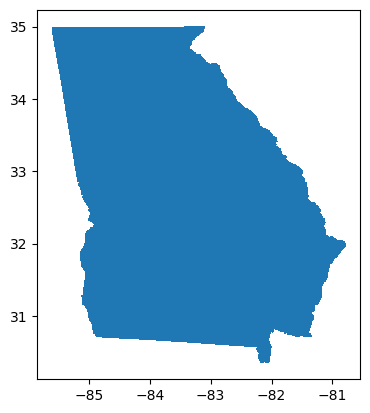

In [ ]:
ga_2021_gdf.plot() # Plot by district, R and D

## 2023 Congressional Map
We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2023 congressional districting map. Since we are using the same senate election as above, the candidates in 2022 were the same: Democrat Raphael Warnock (G22USSDWAR), Libertarian Chase Oliver (G22USSLOLI), and Republican Herschel Junior Walker (G22USSRWAL).

In [ ]:
# Group by congressional district and calculate total votes for each candidate
district_totals = ga_2021_gdf.groupby('DISTRICT')[['G22USSDWAR', 'G22USSRWAL', 'G22USSLOLI']].sum()

# Determine the winning party in each district
district_totals['Winner'] = np.where(
    (district_totals['G22USSDWAR'] > district_totals['G22USSRWAL']) & (district_totals['G22USSDWAR'] > district_totals['G22USSLOLI']),
    "Democrat",
    np.where(
        (district_totals['G22USSRWAL'] > district_totals['G22USSDWAR']) & (district_totals['G22USSRWAL'] > district_totals['G22USSLOLI']),
        "Republican",
        "Libertarian"
    )
)

# Reset index to turn District back into a column (optional)
district_totals_2023 = district_totals.reset_index()

print(district_totals_2023)

   DISTRICT  G22USSDWAR  G22USSRWAL  G22USSLOLI      Winner
0         1      112701      147908        4742  Republican
1        10      120483      187712        6843  Republican
2        11      134994      176447        9222  Republican
3        12      114413      150521        3944  Republican
4        13      228139       47810        4095    Democrat
5        14       85675      176092        6301  Republican
6         2      131503      109100        3112    Democrat
7         3      114843      202738        7593  Republican
8         4      228125       54603        4995    Democrat
9         5      254275       43060        4695    Democrat
10        6      144653      191204       10128  Republican
11        7      148556       83108        5637    Democrat
12        8       90283      168933        4098  Republican
13        9       86853      200997        7901  Republican


In [ ]:
# Count the number of districts won by each party
winner_summary_2023 = district_totals_2023['Winner'].value_counts()

print(winner_summary_2023)

Winner
Republican    9
Democrat      5
Name: count, dtype: int64


In [ ]:
to_plot = ga_2023_gdf.merge(district_totals_2023[["DISTRICT", "Winner"]], on='DISTRICT', how='left')

<Axes: >

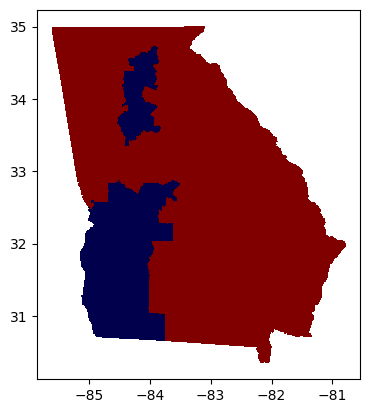

In [ ]:
to_plot.plot(column = "Winner", cmap = "seismic") # but i want to see the districts

<Axes: >

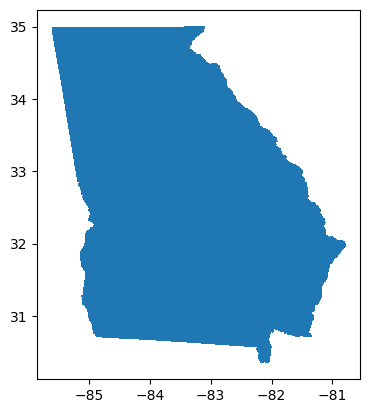

In [ ]:
ga_2023_gdf.plot()